In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [17]:
data = pd.read_csv('./Assets/data.csv', index_col = 'Date')
data = data.iloc[:2665, :]
data

(2665, 59)

In [18]:
data['y'] = data['Close']

x = data.iloc[:, :59].values
y = data.iloc[:, 59].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split - 20:, :]
train_y, test_y = y[: split, ], y[split - 20: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2132, 59) trainY: (2132,)
testX: (553, 59) testY: (553,)


In [19]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [20]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([59, 400, 400, 400, 10], 10)

[1/300] Loss: 534.0762386322021
[2/300] Loss: 506.0137405395508
[3/300] Loss: 484.01805877685547
[4/300] Loss: 469.18411445617676
[5/300] Loss: 473.50729751586914
[6/300] Loss: 475.0123405456543
[7/300] Loss: 455.1666889190674
[8/300] Loss: 438.77057456970215
[9/300] Loss: 436.0185832977295
[10/300] Loss: 438.56939697265625
[11/300] Loss: 438.41511726379395
[12/300] Loss: 432.58914947509766
[13/300] Loss: 421.8974189758301
[14/300] Loss: 409.3665428161621
[15/300] Loss: 399.70478534698486
[16/300] Loss: 398.0135917663574
[17/300] Loss: 403.39537811279297
[18/300] Loss: 402.93227672576904
[19/300] Loss: 389.7243642807007
[20/300] Loss: 376.00556468963623
[21/300] Loss: 370.2910785675049
[22/300] Loss: 370.1518278121948
[23/300] Loss: 371.05320167541504
[24/300] Loss: 370.33788299560547
[25/300] Loss: 367.0475311279297
[26/300] Loss: 361.1435537338257
[27/300] Loss: 352.9289436340332
[28/300] Loss: 343.0858335494995
[29/300] Loss: 332.8896369934082
[30/300] Loss: 324.2866373062134
[31/30

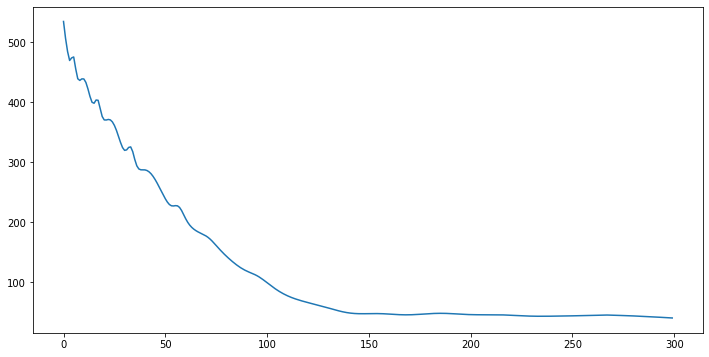

In [21]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [22]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [23]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [24]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [25]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2129, 3, 69]) train_y: torch.Size([2129, 1]) train_y_gan: torch.Size([2129, 4, 1])
test_x: torch.Size([550, 3, 69]) test_y: torch.Size([550, 1]) test_y_gan: torch.Size([550, 4, 1])


In [26]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out_6 = self.linear_3(out_5)
        return out_6

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 5, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.linear2 = nn.Linear(220, 220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out = self.linear3(out_2)
        return out

In [27]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000115
num_epochs = 100
critic_iterations = 5
weight_clip = 0.01

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(69).to(device)
modelD = Discriminator().to(device)

optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        critic_real = modelD(y)
        critic_fake = modelD(fake_data)
        lossD = -(torch.mean(critic_real) - torch.mean(critic_fake))
        modelD.zero_grad()
        lossD.backward(retain_graph = True)
        optimizerD.step()

        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()

        loss_D.append(lossD.item())
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/100] LossD: -0.006149494554847479 LossG:-0.11499320808798075
[2/100] LossD: -0.018583119846880436 LossG:-0.13319241302087903
[3/100] LossD: -0.02723793126642704 LossG:-0.1638245629146695
[4/100] LossD: -0.002676190808415413 LossG:-0.2205347940325737
[5/100] LossD: 0.03250036854296923 LossG:-0.22394847217947245
[6/100] LossD: 0.005954115651547909 LossG:-0.19144277554005384
[7/100] LossD: -0.0011602360755205154 LossG:-0.18667034432291985
[8/100] LossD: -0.003159676678478718 LossG:-0.18546039145439863
[9/100] LossD: -0.004696564748883247 LossG:-0.1794681679457426
[10/100] LossD: -0.00555427186191082 LossG:-0.17314218822866678
[11/100] LossD: -0.005739465355873108 LossG:-0.16405075695365667
[12/100] LossD: -0.0052145300433039665 LossG:-0.15904766274616122
[13/100] LossD: -0.004595702514052391 LossG:-0.13644247129559517
[14/100] LossD: -0.004542247857898474 LossG:-0.12376456335186958
[15/100] LossD: -0.005308127962052822 LossG:-0.10798795381560922
[16/100] LossD: -0.0066157178953289986 L

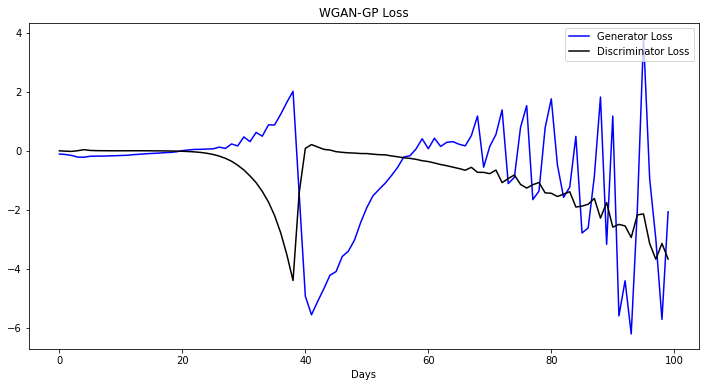

In [28]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('WGAN-GP Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [29]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:1.7516240830950527


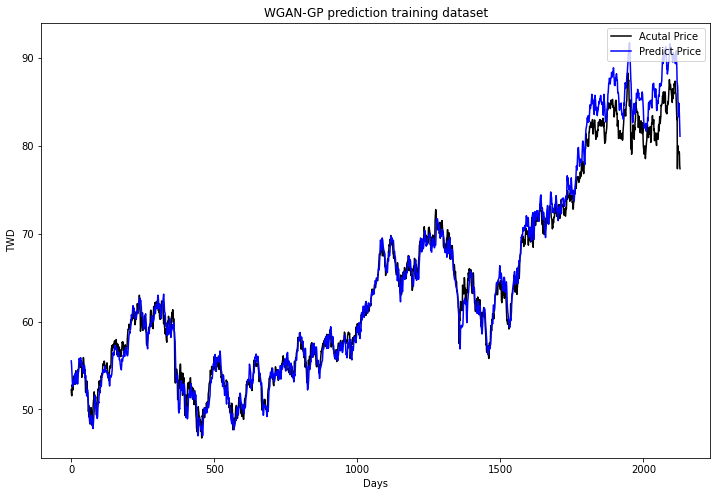

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:2.5599527056111873


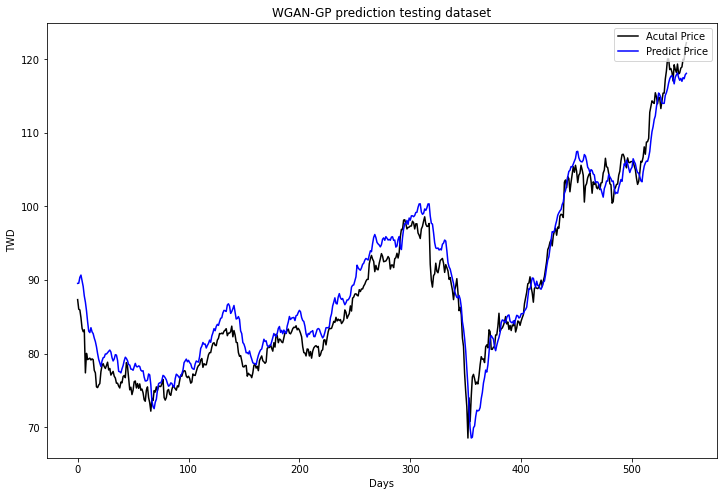

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')